In [ ]:
import os
import time
import shutil
import pathlib
import itertools


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

In [ ]:
#Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # check if there are another folders
            if pathlib.Path(foldpath).suffix == '':
                # check unneeded masks
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
data_dir = '/content/drive/MyDrive/Transfert_Learning/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 128
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 14822 validated image filenames belonging to 4 classes.
Found 3176 validated image filenames belonging to 4 classes.
Found 3177 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

efficientnet_model = EfficientNetB0()

efficientnet_model.summary()

21834768/21834768 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
X = efficientnet_model.layers[-2].output
X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
X = tf.keras.layers.Dense(units=512, activation='relu')(X)
output = tf.keras.layers.Dense(units=4, activation='softmax')(X)

In [ ]:
efficientnet_model1 = tf.keras.models.Model(inputs = efficientnet_model.input, outputs=output)

In [ ]:
efficientnet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
for layer in efficientnet_model1.layers[:-3]:
    layer.trainable = False

In [ ]:
efficientnet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
efficientnet_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
timeVal = time.time()
history = efficientnet_model1.fit(x=train_gen, validation_data=valid_gen, epochs=10, verbose=1)
print(time.time() - timeVal)

Epoch 1/10
116/116 [==============================] - 5184s 44s/step - loss: 0.5331 - accuracy: 0.7977 - val_loss: 0.3270 - val_accuracy: 0.8813
Epoch 2/10
116/116 [==============================] - 1859s 16s/step - loss: 0.3692 - accuracy: 0.8587 - val_loss: 0.2889 - val_accuracy: 0.8945
Epoch 3/10
116/116 [==============================] - 1917s 16s/step - loss: 0.3295 - accuracy: 0.8764 - val_loss: 0.3101 - val_accuracy: 0.8788
Epoch 4/10
116/116 [==============================] - 1863s 16s/step - loss: 0.3095 - accuracy: 0.8840 - val_loss: 0.2859 - val_accuracy: 0.8892
Epoch 5/10
116/116 [==============================] - 1920s 17s/step - loss: 0.2979 - accuracy: 0.8867 - val_loss: 0.2667 - val_accuracy: 0.8980
Epoch 6/10
116/116 [==============================] - 1896s 16s/step - loss: 0.2827 - accuracy: 0.8941 - val_loss: 0.2628 - val_accuracy: 0.9002
Epoch 7/10
116/116 [==============================] - 1957s 17s/step - loss: 0.2558 - accuracy: 0.9041 - val_loss: 0.2527 - val_ac

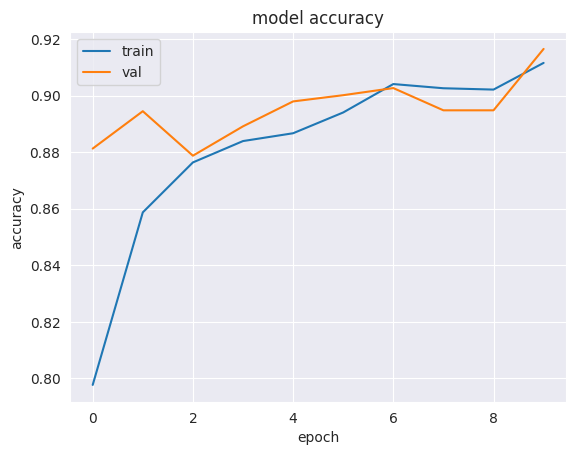

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

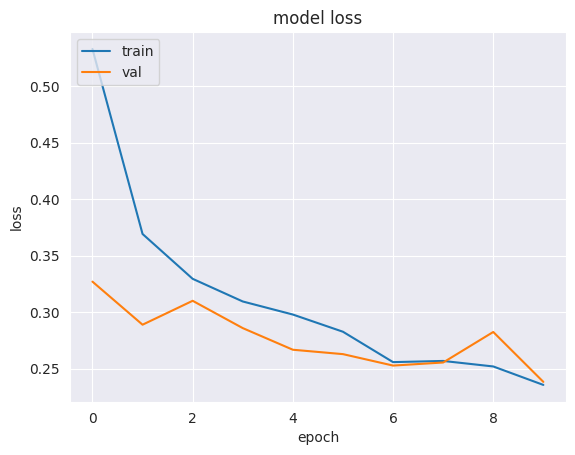

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen.classes

In [19]:
predictions = efficientnet_model1.predict(x=test_gen, verbose=0)

In [20]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [21]:
test_gen.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [22]:
cm_plot_labels = ['COVID','Lung_Opacity','Normal','Viral Pneumoni']

Text(0.5, -46.26993134838366, 'Predicted label')

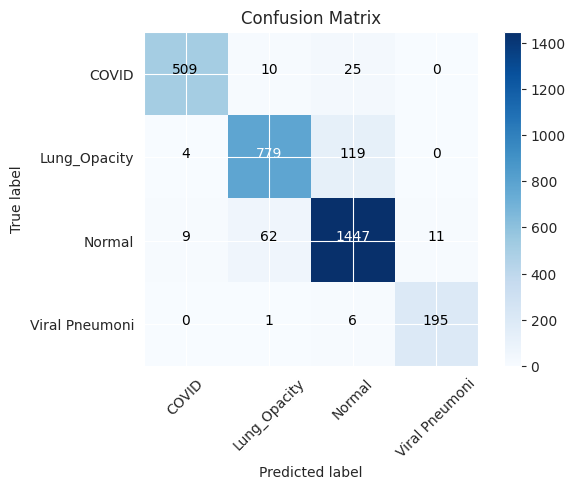

In [23]:
import itertools

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_plot_labels))
plt.xticks(tick_marks, cm_plot_labels, rotation=45)
plt.yticks(tick_marks, cm_plot_labels)

thresh = cm.max()/2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [24]:
report = classification_report(test_labels, predictions.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.94      0.95       544
           1       0.91      0.86      0.89       902
           2       0.91      0.95      0.93      1529
           3       0.95      0.97      0.96       202

    accuracy                           0.92      3177
   macro avg       0.94      0.93      0.93      3177
weighted avg       0.92      0.92      0.92      3177

